In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Cost of Carry - CTD (T-Bonds)

In [2]:
# Conversion Factor
def conversion_factor(C,T):
    n = math.floor(T*2)
    summation = 0
    for i in range(1,n):
        summation = summation + ((C/2)/(1.03**i))
    disc = summation + (100 + (C/2))/(1.03**n)
    if T%.5 == 0.25:
        disc = disc/1.014889
    return round(disc,4)

# Bond dirty price
def P(T,C,r):
    n = math.floor(T*2)
    coupon_sum = 0
    acc_interest = 0
    for i in range(1,n):
        coupon_sum += ((C/2)*np.exp(-(r/2)*i))
    clean_price = coupon_sum + (100 + (C/2))*np.exp(-(r/2)*(n))
    acc_interest = a(C,T)
    return clean_price + acc_interest

# Accrued interest
def a(C, T):
    if T%.5 == 0.25:
        return (C/2)*(1/2)
    else:
        return 0

# Delivery Profit
def delivery_profit(Phi_t, C, P, cf, T, T_f, r):
    return (Phi_t*(cf/100) + a(C, (T-T_f)%.5)) - ((P + a(C, T))*(1+r)**T_f)

In [3]:
# Bond data from fiscaldata.treasury.gov
# t = 3/15/2023
# Maturity (T-t) is rounded to the nearest .25 years

df = pd.read_csv("deliverable_bonds.csv")
df["Yield"] = df["Yield"]/100
df.head()

,Ticker,Coupon,Yield,T-t
0,912810PX0,4.500,0.04609,15.25
1,912810QA9,3.500,0.03540,16.00
2,912810QB7,4.250,0.04288,16.25
3,912810QC5,4.500,0.04541,16.50
4,912810QD3,4.375,0.04469,16.75


### Calculate bond prices and conversion factors

In [4]:
conversion_factors = list()
bond_prices = list()
for i in range(0,len(df)):
    bond_prices.append(P(df["T-t"][i],df["Coupon"][i],df["Yield"][i]))
    conversion_factors.append(conversion_factor(df["Coupon"][i],df["T-t"][i]))
df["P"] = bond_prices
df["cf"] = conversion_factors

### Calculate delivery profits

In [5]:
# Sept '23 U.S. treasury bond future on 3/3 (ZBM3)
Phi_t = 123+(31/32)
T_f = 0.5

# 10yr treasury rate on 3/3 (risk-free rate)
r = .0397

delivery_profits = list()
for i in range(0,len(df)):
    delivery_profits.append(delivery_profit(Phi_t, df["Coupon"][i], df["P"][i], df["cf"][i], df["T-t"][i], T_f, r))
df["delivery_profit"] = delivery_profits
df

,Ticker,Coupon,Yield,T-t,P,cf,delivery_profit
0,912810PX0,4.500,0.04609,15.25,99.385326,84.0483,2.832589
1,912810QA9,3.500,0.03540,16.00,99.134108,74.5140,-8.708694
2,912810QB7,4.250,0.04288,16.25,100.096948,80.9545,-1.727138
3,912810QC5,4.500,0.04541,16.50,98.932969,84.4257,3.783810
4,912810QD3,4.375,0.04469,16.75,99.428135,81.9083,0.136622
...,...,...,...,...,...,...,...
63,912810TB4,1.875,0.01940,28.75,98.846950,43.3557,-47.051660
64,912810TD0,2.250,0.02340,29.00,97.828515,48.7544,-39.311290
65,912810TG3,2.875,0.02997,29.25,97.938615,56.4547,-29.891717
66,912810TJ7,3.000,0.03106,29.50,97.503550,58.7413,-26.599302


### CTD for Sept '23 T-Bond future (as of 3/15/2023):

In [6]:
CTD = df.loc[np.where(df["delivery_profit"] == df["delivery_profit"].max())[0][0]]
CTD

Ticker             912810QN1
Coupon                  4.75
Yield                 0.0475
T-t                     18.0
P                  99.320225
cf                   86.3548
delivery_profit     5.780423
Name: 12, dtype: object

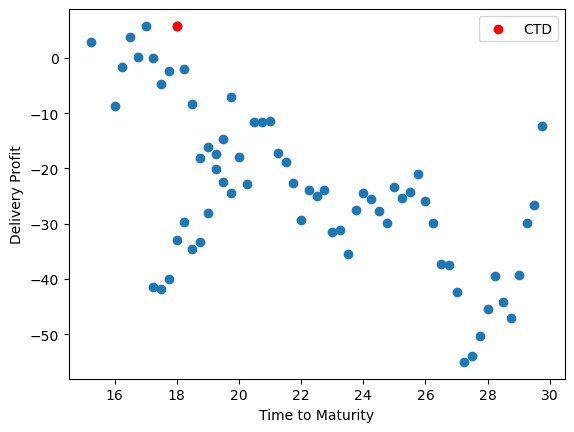

In [7]:
plt.scatter(df["T-t"],df["delivery_profit"])
plt.scatter(CTD["T-t"],CTD["delivery_profit"],color="red",label="CTD")
plt.legend()
plt.ylabel("Delivery Profit")
plt.xlabel("Time to Maturity")
plt.show()